In [136]:
import pandas, numpy, requests, geopandas, pysal, matplotlib.pyplot as plt
from scipy import stats
from shapely.geometry import Polygon, mapping
from fitter import Fitter
import warnings
warnings.filterwarnings("ignore")
# pysal documentation: https://splot.readthedocs.io/en/latest/api.html#
# pysal edsa: https://pysal.org/esda/notebooks/spatialautocorrelation.html

### Load, recode, geocode Chicago Open Data Portal Crimes from 2001

In [2]:
df = pandas.read_csv('C:/Benchmark Analytics/Chicago Data Portal/Crimes_-_2001_to_Present.csv')
# Recode, clean
df['Primary Type'] = df['Primary Type'].str.lower()
df['Primary Type'] = df['Primary Type'].replace({'non - criminal':'non-criminal','non-criminal (subject specified)':'non-criminal',\
                                               'crim sexual assault':'criminal sexual assault'})
df['date'] = pandas.to_datetime(df['Date'])

# Dropping crimes w/missing geographies for now (<0.1% of total)
df = df.dropna(subset=['Location', 'Police Beats'], axis=0)
# Encode crimes as Geopandas point objects to later fit into police beat shapefiles
dfg = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude))

<AxesSubplot:>

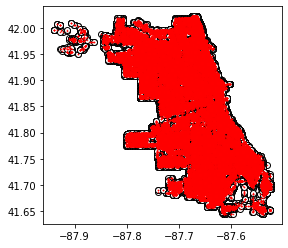

In [15]:
# Plot (not necessary to run)
ax = rec.plot(color='white', edgecolor='black')
rec.plot(ax=ax, color='red', marker=".", markersize=1)

In [ ]:
# Investigate how beat deprecation is treated in crimes file
odf = df[df['date']<=pandas.to_datetime('12/18/2012')]
ndf = df[df['date']>=pandas.to_datetime('12/18/2012')]
ob = odf['Beat'].dropna().astype(int).unique().tolist()
nb = odf['Beat'].dropna().astype(int).unique().tolist()
ob == nb #True
# Exact same set of beats before & after beat deprecation on 12/18/2012 - file must have placed old crimes in current beats

### Chicago PD beat shapefiles

In [54]:
# Beats Shapefiles - Current
new_beats = geopandas.read_file('C:/Benchmark Analytics/Chicago Data Portal/beats/Boundaries - Police Beats (current).zip')
new_beats = new_beats.sort_values(by=['district', 'sector', 'beat', 'beat_num']) # remove leading zero on district number
new_beats['beat_num'] = new_beats['beat_num'].str.lstrip('0')

# Beats Shapefiles - effective 12/19/2012 (apparently 2 diff web pages for the same beat shapefiles)
#val_path = 'C:/Benchmark Analytics/Chicago Data Portal/beats/Boundaries - Police Beats (effective 12_19_2012).zip'
#val_beats = geopandas.read_file(val_path)
#val_df = val_beats == beats 
#val_df.sum() == len(val_df)
#val_df.sum() == len(beats)
# files are exactly the same

In [55]:
# Beats Shapefiles - deprecated 12/18/2012: https://data.cityofchicago.org/Public-Safety/Boundaries-Police-Beats-deprecated-on-12-18-2012-/kd6k-pxkv
old_path = 'C:/Benchmark Analytics/Chicago Data Portal/beats/PoliceBeats.zip'
old_beats = geopandas.read_file(old_path)
old_beats.columns = old_beats.columns.str.lower()
old_beats = old_beats.sort_values(by=['district', 'sector', 'beat', 'beat_num']) # remove leading zero on district number
old_beats['beat_num'] = old_beats['beat_num'].str.lstrip('0')

# Reproject old beats to lat/lon coordinates
old_beats = old_beats.to_crs(epsg=4326)

# Combine beat files
old_beats['version'] = 'old'
new_beats['version'] = 'new'
beats = pandas.concat([new_beats, old_beats])
beats = beats.sort_values(by=['beat_num'])
beats = beats.reset_index(drop=True)
beats['coors'] = beats['geometry'].apply(mapping)

In [56]:
# New and deprecated beats
old_beat_ids = old_beats.beat_num.values.tolist()
new_beat_ids = new_beats.beat_num.values.tolist()
new_beat_ids == old_beat_ids # False
new_ids = [x for x in new_beat_ids if x not in old_beat_ids]
deprecated_ids = [x for x in old_beat_ids if x not in new_beat_ids]
print('new beats: ', new_ids)
print('deprecated beats: ', deprecated_ids)

In [ ]:
# Compare old and new beats to see whether the polygon changed
beat_compare = pandas.DataFrame(index=beats.beat_num.unique())
for b in beats.beat_num.unique().tolist():
    comparison = beats[beats['beat_num']==b]
    try:
        beat_compare.loc[b, 'match'] = comparison.geometry.values.tolist()[0] == comparison.geometry.values.tolist()[1]
    except:
        print(b)
# Polygon comparison evaluates to False even though all dimensions are the same - geopandas quirk (?) - using current beats for now
#beats[beats.beat_num.isin(new_ids)].plot()
#new_beats.plot()
#old_beats.plot()

In [58]:
# Crime "Primary Type" distribution by Beat
beat_crimes = []
for beat_num in df.Beat.unique():
    d = df[df['Beat']==beat_num]
    beat_crimes.append({beat_num: d['Primary Type'].value_counts()})
# Dataframe
ctb = pandas.DataFrame(beat_crimes[0]).transpose()
for item in beat_crimes[1:]:
    ctb = pandas.concat([ctb, pandas.DataFrame(item).transpose()])
ctb['total'] = ctb.sum(axis=1)
ctb.index = ctb.index.astype(str)

In [133]:
ctb.head(1) # beat number is dataframe index

,theft,battery,criminal damage,assault,other offense,narcotics,burglary,deceptive practice,motor vehicle theft,robbery,...,obscenity,public indecency,concealed carry license violation,non-criminal,ritualism,human trafficking,other narcotic violation,homicide,domestic violence,total
924,5578,4607,3550,1975,1727.0,1710.0,1515.0,1220,1119.0,680.0,...,3.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,25602.0


In [67]:
# Merge crimes & types to beat shapefiles
bc = new_beats.merge(ctb, left_on='beat_num', right_index=True)
bc = bc.fillna(0)

### Histogram - Total Crimes by Beat

array([[<AxesSubplot:title={'center':'total'}>]], dtype=object)

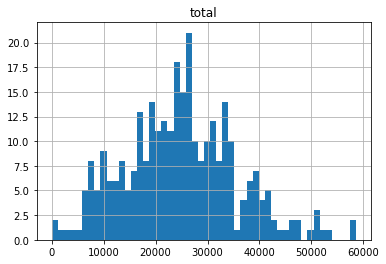

In [135]:
ctb.hist(column='total', bins=50)

### Choropleth - Crimes by Beat

<AxesSubplot:>

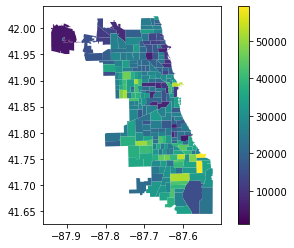

In [62]:
bc.plot('total', legend=True)

### Fitting Distributions on Crime Counts across Beats

In [137]:
f = Fitter(ctb.total) # MLE parameter estimation of 106 scipy distributions for total crimes by beat
f.fit()

Fitting 106 distributions: 100%|█████████████████████████████████████████████████████| 106/106 [01:15<00:00,  1.41it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
burr,8.475461e-09,2302.251448,-7339.991635,inf,0.033683,0.870121
gennorm,8.487127e-09,2309.505595,-7345.288573,inf,0.037757,0.766019
mielke,8.517394e-09,2302.150060,-7338.496194,inf,0.033676,0.870277
logistic,8.555712e-09,2307.364702,-7348.563592,inf,0.027811,0.968109
tukeylambda,8.613286e-09,2309.777424,-7340.817703,inf,0.041548,0.656602


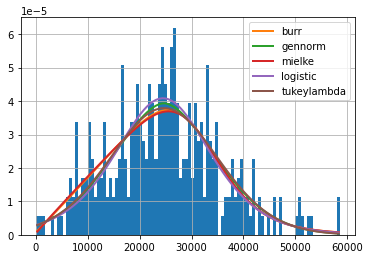

In [138]:
f.summary() # top 5 best fitting distributions & KS test results of data to fit dist.
# Prefer a distribution permitting skew as data appear to be skewed, even though best KS fit is the symmetric logistic dist.
# Mielke allows skew

In [40]:
f.fitted_param # Grabbing fitted params of mielke dist.

{'anglit': (28302.265279198917, 39006.892135396316),
 'arcsine': (16.999999999999996, 58696.889367810734),
 'bradford': (0.985711621479072, 16.99999289435892, 58602.00010773001),
 'argus': (1.5097534537712656e-07, -7987.663146251963, 66693.01234269707),
 'cauchy': (24423.284346070264, 6268.335409145882),
 'alpha': (0.0002645259878104441, -0.7848378496425408, 317.7455013365443),
 'cosine': (26415.913572771446, 10638.64357957718),
 'beta': (8.456092792847597,
  20.947664618423048,
  -13062.501782622354,
  131541.9659510153),
 'chi': (0.00024209146914775032, 50807.99999999999, 17.017296128309766),
 'dgamma': (1.2457693392801568, 25102.125917859907, 6790.438982500845),
 'chi2': (62.7749702326267, -35721.251526379965, 963.5905901359351),
 'expon': (17.0, 24751.118811881188),
 'betaprime': (31.635747182402053,
  5565.03037590741,
  -35812.12031104708,
  10655238.844544511),
 'dweibull': (1.169232648809766, 24459.990114532964, 8883.647578263957),
 'burr12': (2.6591406938350515,
  1845.0000217

### Function - percentile of Chicago crime in beat during given window

In [123]:
def crime_compare(crime_df, beat, start, end):
    """crime_df: df of crimes from Chicago Open Data Portal
       beat: 1 of 303 beats (policing subdivisions of Chicago)
       start: first day of comparison window, format: 1/1/2015
       end: last day of comparison window, format 12/31/2015
       returns: Beat's percentile of total crimes in window - fit by mielke distribution (to allow skew)""" 
    
    df = crime_df[crime_df['date']>=pandas.to_datetime(start)]
    df = df[df['date']<=pandas.to_datetime(end)]
    bybeat = df.Beat.value_counts().to_dict()
    beat_count = bybeat[beat]
    vals = numpy.array(list(bybeat.values()))
    mielke_params = stats.mielke.fit(vals)
    mielke = stats.mielke(mielke_params[0],mielke_params[1],mielke_params[2],mielke_params[3])
    print('mean: ', mielke.mean(), 'median: ', mielke.median())
    return(mielke.cdf(beat_count))

In [127]:
crime_compare(df, beat=303, start='1/1/2015', end='12/31/2015')

KeyError: 303

### Severity Comparison across Beats - 22 Ordinal Rankings from UCR

In [ ]:
# Descriptions of crimes by Primary Type
df[df['Primary Type']=='ritualism'].Description.value_counts()

In [129]:
# 22 ordinal severity rankings of crime, adapted from Universal Crime Reporting guidelines
sev = pandas.read_excel('C:/Benchmark Analytics/Chicago Data Portal/crimes_severity.xlsx')
sev['severity'] = 22 - sev['severity']
df = df.merge(sev, how='left', left_on='Primary Type', right_on='primary type')

array([[<AxesSubplot:title={'center':'severity'}>]], dtype=object)

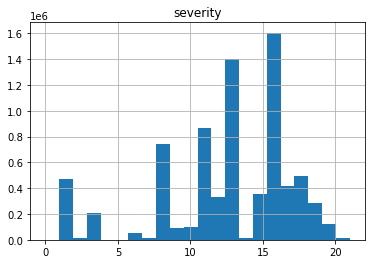

In [140]:
df.hist(column='severity', bins=22)

In [ ]:
# CDFs of crime severity distribution, overall and for each beat
hist, bins = numpy.histogram(df['severity'], bins=22)
pdf = hist / sum(hist)
cdf = numpy.cumsum(pdf)
cdfs = {}
for beat in df.Beat.unique():
    d = df[df['Beat']==beat]
    hist, bins = numpy.histogram(d['severity'], bins=22)
    pdf = hist / sum(hist)
    cdf = numpy.cumsum(pdf)
    cdfs[beat] = cdf

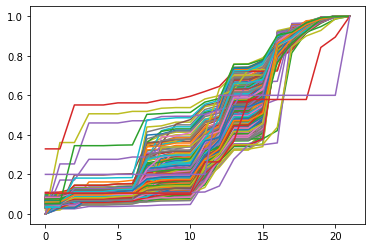

In [132]:
# Plot crime severity CDFs of all beats
plt.plot(cdf, color='black')
for key in cdfs.keys():
    plt.plot(cdfs[key])

In [ ]:
# Kolmogorov-Smirnov tests, comparing crime severity dist. in each beat to overall dist.
ks = {}
for key in cdfs.keys():
    ks[key] = stats.kstest(cdf, cdfs[key])
ks # Results, ctrl+F "pvalue=0.0" to find rejected beats

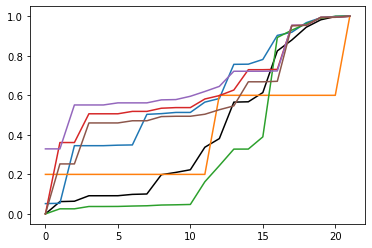

In [139]:
# KS test significant for 6 beats
reject_beats = [134, 310, 1214, 1653, 1652, 1655]
plt.plot(cdf, color='black') # overall dist. in black
for beat in reject_beats:
    plt.plot(cdfs[beat])
# Increase ordinality of crime severity to potentially reject more beats
# How to encode divergent crime severity distributions as features?